Source: [part 5](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)

In [1]:
import os
from IPython.display import Image

pth = os.getcwd()
pth


'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 5 - Convolutional Sequence to Sequence Learning

In this notebook we'll be implementing the [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122) model. 

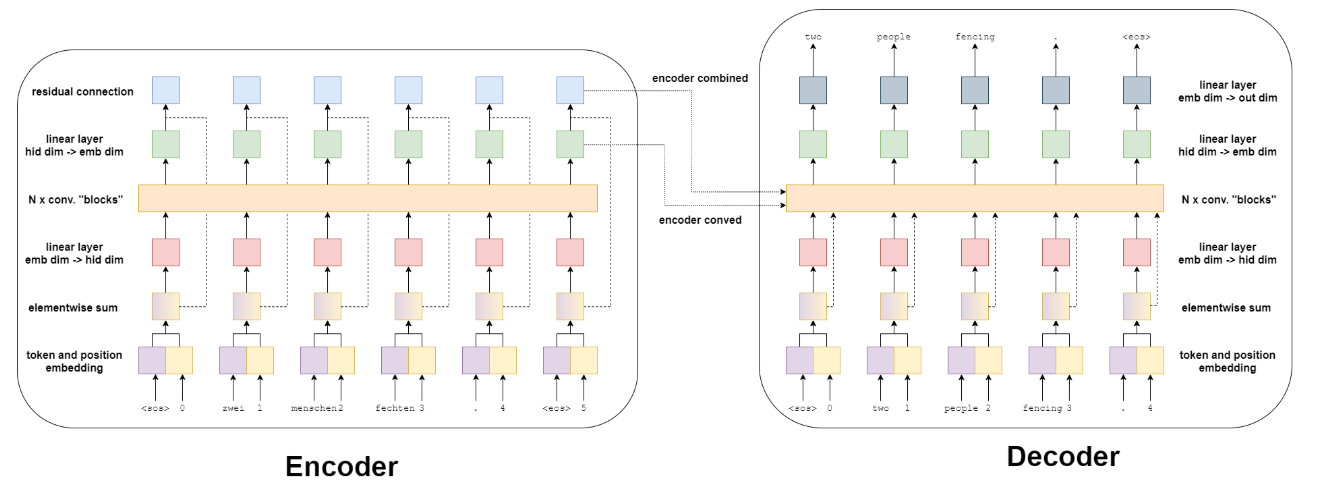

In [2]:
Image(filename = pth + "/images/5_1_cnnseq2seq.png")

## Introduction

This model is drastically different to the previous models used in these tutorials. There is are no recurrent components used at all. Instead it makes use of convolutional layers, typically used for image processing. 

In short, a convolutional layer uses *filters*. These filters have a *width* (and also a *height* in images, but usually not text). If a filter has a width of 3, then it can see 3 consecutive tokens. Each convolutional layer has many of these filters (1024 in this tutorial). Each filter will slide across the sequence, from beginning to the end, looking at all 3 consectuive tokens at a time. The idea is that each of these 1024 filters will learn to extract a different feature from the text. The result of this feature extraction will then be used by the model - potentially as input to another convolutional layer. This can then all be used to extract features from the source sentence to translate it into the target language.


## Preparing the Data

First, let's import all the required modules and set the random seeds for reproducability.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import spacy

import random
import math
import time

In [4]:
# Set random seeds for reproducibility

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [12]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
#spacyDE = spacy.load('de')

spacyEN = spacy.load('en')
spacyFR = spacy.load('fr') # french!
spacySP = spacy.load('es') # spanish!

# site link for other language models: https://spacy.io/usage/models

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [13]:
# Creating the tokenizer functions

def tokenizeFrench(frenchText: str):
    """
    Tokenizes French text from a string into a list of strings (as tokens)
    :param frenchText: 
    :return: 
    """
    return [tok.text for tok in spacyFR.tokenizer(frenchText)]



def tokenizeSpanish(spanishText: str):
    """
    Tokenizes Spanish text from a string into a list of strings (as tokens)
    :param spanishText: 
    :return: 
    """
    return [tok.text for tok in spacySP.tokenizer(spanishText)]


def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with French (or spanish) being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)

 **Difference this time:** By default RNN models in PyTorch require the sequence to be a tensor of shape **[sequence length, batch size]** so TorchText will, by default, return batches of tensors in the same shape. However in this notebook we are using CNNs which expect the batch dimension to be first. We tell TorchText to have batches be **[batch size, sequence length]** by setting `batch_first = True`.  

We also append the start and end of sequence tokens as well as lowercasing all text.

In [14]:
SRC_french = Field(tokenize = tokenizeFrench,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

SRC_spanish = Field(tokenize = tokenizeSpanish,
                   init_token = '<sos>',
                   eos_token = '<eos>',
                   lower = True,
                   batch_first = True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset)